__BIOBSS - ACC Pipeline__

_This notebook includes guidelines to help using pipeline module for ACC signal processing and feature extraction._

In [36]:
#Import BIOBSS and other required packages

#import biobss
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import biobss from local to run without installing
import sys
sys.path.append("../")
import biobss

# Table of Contents
1. [ACC Sample Data](#sampledata)<br>
2. [Peak Detection](#acc_peak)<br>
3. [Create Bio Process Objects](#create_bioprocess)<br>
4. [Create Feature Objects](#create_feature)<br>
5. [Create Bio Pipeline Object](#create_pipeline)<br>
6. [Create Bio Channel Objects](#create_biochannel)<br>
7. [Set Pipeline Inputs](#set_input)<br>
8. [Add Bio Process Objects to Pipeline](#add_bioprocess)<br>
9. [Add Feature Objects to Pipeline](#add_feature)
10. [Run Pipeline](#run_pipeline)<br>
11. [Extract Features](#extract_features)<br>

### __ACC Sample Data__
<a id="sampledata"></a>

ACC sample data is provided as a csv file in BIOBSS\sample data. The data file contains 3-axis ACC signals of 5-minutes length, sampled at 32 Hz. 

In [37]:
#Load the sample data
data, info = biobss.utils.load_sample_data(data_type='ACC')
accx = np.asarray(data['ACCx'])
accy = np.asarray(data['ACCy'])
accz = np.asarray(data['ACCz'])
fs = info['sampling_rate']
L = info['signal_length']

### __Create Bio Process Objects__
<a id="create_bioprocess"></a>

Any process can be added to the pipeline if the input is a signal and ouput is a signal or collection of signals. The process can be added by passing the method to a Bio_Process constructor. The Bio_Process constructor takes the following arguments:

- process_method: The method to be added to the pipeline
- inplace: If True, result of the process will modify the input signal. If False, the result of the process will be returned as a new signal and added as a new channel.
- prefix: The prefix to be added to the output channel name. If inplace is True, prefix will be ignored.
  - If inplace is False, the output channel name will be prefix + input channel name.
  - <code> (Default: None) (if inplace = False  and prefix = None, prefix will be set to 'processed') </code>
- return_index : If a return_index is set, selected index of the result will be set as result. If return_index is None, the whole result will be set as result. (Default: None)
- argmap: this dictionary maps different named arguments. For example, Bio_Channel already have a sampling_rate attribute. If the process method requires sampling rate with a different name, it can be mapped to the Bio_Channel attribute.<code> EXAMPLE : argmap = {'sampling_rate': 'fs'} or argmap = {'sampling_rate': 'sample_rate'} </code>
- **kwargs: Keyword arguments to be passed to the process method






Pipeline processes the given input sequentially. The input is passed from one process to the next.

In [38]:
# Create steps for the pipeline

# Filter steps process,return filtered signal for all input signals
clean=biobss.pipeline.Bio_Process(process_name="clean",
    process_method=biobss.preprocess.filter_signal, argmap={"sampling_rate":"sampling_rate"}, signal_type='ACC', method='lowpass')

# Signal normalization step, return normalized signal for all input sisgnals
normalize = biobss.pipeline.Bio_Process(process_name="normalize",
    process_method=biobss.preprocess.normalize_signal)



### __Create Feature Objects__
<a id="create_feature"></a>

In [39]:
# Create feature extraction steps

# Extract time domain features. input_signals dictionary contains feature prefixes as keys and input signals as values
# For example rms of EDA_Tonic is extracted as Tonic_rms in this case
#corr_features = biobss.pipeline.Feature(name="corr_features", function=biobss.imutools.get_corr_features, parameters={"modality": "ACC", "sigtype": "ACC","signal_names":['ACCx','ACCy','ACCz']}, input_signals={'ACC':['ACCx', 'ACCy', 'ACCz']}, sampling_rate=fs)
#freq_features = biobss.pipeline.Feature(name="freq_features", function=biobss.imutools.get_freq_features, parameters={"modality": "ACC", "sigtype": "ACC","signal_names":['ACCx','ACCy','ACCz']}, input_signals={'ACC':['ACCx', 'ACCy', 'ACCz']}, sampling_rate=fs, prefix='signal')
#stat_features = biobss.pipeline.Feature(name="stat_features", function=biobss.imutools.get_stat_features, parameters={"modality": "ACC", "sigtype": "ACC","signal_names":['ACCx','ACCy','ACCz']}, input_signals={'ACC':['ACCx', 'ACCy', 'ACCz']}, sampling_rate=fs)
acc_features = biobss.pipeline.Feature(name="acc_features", function=biobss.imutools.get_acc_features,  sampling_rate=fs, magnitude=True)

### __Create Bio Pipeline Object__
<a id="create_pipeline"></a>

In [40]:
# BIOBSS Pipeline is created
# windowed_process=True means that the pipeline will process the signal in windows
# window_size=60 means that the pipeline will process 60 seconds of data at a time
# step_size=20 means signal will be shifted by 20 seconds for each window
pipeline = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=10,step_size=5)

### __Create Bio Channel Objects__
<a id="create_biochannel"></a>

In [41]:
# Input is created as Bio_Channel object
# Bio_Channel object requires following parameters: name, signal, sampling_rate
# Optionally timestamp can be provided
# If timestamp is provided, resolution of the timestamp should be provided. Possible resolutions are:'min', 's', 'ms', 'us'
# If timestamp is not provided, timestamp will be created using sampling_rate. Default resolution is 's'
channel_x=biobss.pipeline.Bio_Channel(signal=accx,name="ACCx",sampling_rate=fs)
channel_y=biobss.pipeline.Bio_Channel(signal=accy,name="ACCy",sampling_rate=fs)
channel_z=biobss.pipeline.Bio_Channel(signal=accz,name="ACCz",sampling_rate=fs)

# a Bio Channel object is created with sample data, with the name EDA_Raw and sampling rate 700
# timestamp is not provided, so timestamp will be created using sampling_rate

# Simply bio_channel the channel object will print the channel properties
channel_x

ACCx (32Hz) ((60.0,)s) (1 windows) ((1920,)) ((1920,)) (int64)[-27 -27 -27 ... -46 -45 -46]

In [42]:
# bio_channel.channel accesses the data in the channel object
channel_x.channel

array([-27, -27, -27, ..., -46, -45, -46], dtype=int64)

### __Create Bio Data Object__
<a id="create_biodata"></a>

In [43]:
bio_data = biobss.pipeline.Bio_Data()

In [44]:
bio_data.add_channel(channel_x, 'ACCx')
bio_data.add_channel(channel_y, 'ACCy')
bio_data.add_channel(channel_z, 'ACCz')

In [45]:
bio_data

Signal object with 3 channel(s)
ACCx (32Hz) ((60.0,)s) (1 windows) ((1920,))
ACCy (32Hz) ((60.0,)s) (1 windows) ((1920,))
ACCz (32Hz) ((60.0,)s) (1 windows) ((1920,))

### __Set Pipeline Inputs__
<a id="set_input"></a>

In [46]:
# Pipeline input can be set from an array, a dataframe, pandas series, list, Bio_Channel, Bio_Data

# In this case, the pipeline input is set with an array
#pipeline.set_input(accx,sampling_rate=fs,name='ACCx_Raw')
#pipeline.set_input(accy,sampling_rate=fs,name='ACCy_Raw')
#pipeline.set_input(accz,sampling_rate=fs,name='ACCz_Raw')

# Alternatively, the pipeline input can be set with a Bio_Channel object, in this case the name and sampling rate are not required as they are already provided in the Bio_Channel object
#pipeline.set_input(channel_x)
#pipeline.set_input(channel_y)
#pipeline.set_input(channel_z)

pipeline.set_input(bio_data)
pipeline.input

Signal object with 3 channel(s)
ACCx (32Hz) ((60.0,)s) (1 windows) ((1920,))
ACCy (32Hz) ((60.0,)s) (1 windows) ((1920,))
ACCz (32Hz) ((60.0,)s) (1 windows) ((1920,))

#### __Add Bio Process Objects to Pipeline__
<a id="add_bioprocess"></a>

In [47]:
# Pipeline steps are added to the pipeline sequentially, the order of the steps is important as the output of one step is the input of the next step
# These steps will be processed in the order they are added to the pipeline
pipeline.preprocess_queue.add_process(clean,input_signals=['ACCx'],output_signals=['ACCx'])
pipeline.preprocess_queue.add_process(clean,input_signals=['ACCy'],output_signals=['ACCy'])
pipeline.preprocess_queue.add_process(clean,input_signals=['ACCz'],output_signals=['ACCz'])
pipeline.preprocess_queue.add_process(normalize,input_signals=['ACCx'],output_signals=['ACCx'])
pipeline.preprocess_queue.add_process(normalize,input_signals=['ACCy'],output_signals=['ACCy'])
pipeline.preprocess_queue.add_process(normalize,input_signals=['ACCz'],output_signals=['ACCz'])



# Currently all the steps are added to the preprocess_queue
# After the preprocess_queue is processed, data will be segmented into windows (if windowed_process=True)
# For running process in windows, the process_queue is used

## This structure will change in the future

#### __Add Feature Objects to Pipeline__
<a id="add_feature"></a>

In [48]:
# Features are added to the pipeline
#pipeline.add_feature_step(corr_features)
#pipeline.add_feature_step(freq_features)
#pipeline.add_feature_step(stat_features)
pipeline.add_feature_step(acc_features, input_signals=[['ACCx','ACCy','ACCz']],signal_names=['X','Y','Z'])

In [49]:
# Represetation of the pipeline
pipeline

Bio_Pipeline:
	Preprocessors: Process list:
	1: clean(ACCx) -> ACCx
	2: clean(ACCy) -> ACCy
	3: clean(ACCz) -> ACCz
	4: normalize(ACCx) -> ACCx
	5: normalize(ACCy) -> ACCy
	6: normalize(ACCz) -> ACCz

	Processors: Process list:

	Postprocessors: Process list:

	Window Size(Seconds): 10
	Step Size: 5

#### __Run Pipeline__
<a id="run_pipeline"></a>

In [50]:
# Pipeline is run, this will process the input data in the pipeline
pipeline.run_pipeline()

In [51]:
# Represetation of the pipeline data after running
pipeline.data

# Data is cleaned
# Data is normalized
# Data is decomposed into tonic and phasic components, these componenets are added to the pipeline data as EDA_Tonic and EDA_Phasic channels
# Lastly, data is resampled to 350Hz (All channels are resampled to 350Hz) (target_sample_rate=350)
# Data is segmented into windows of 60 seconds with a step size of 20 seconds

Signal object with 3 channel(s)
ACCx (32Hz) (10.0s) (11 windows) ((11, 320))
ACCy (32Hz) (10.0s) (11 windows) ((11, 320))
ACCz (32Hz) (10.0s) (11 windows) ((11, 320))

#### __Extract Features__
<a id="extract_features"></a>

IndexError: index 0 is out of bounds for axis 0 with size 0

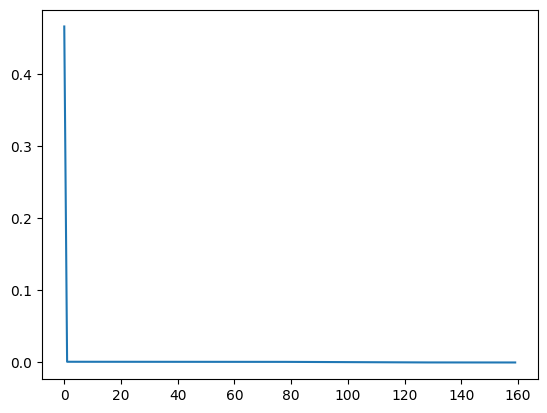

In [55]:
# Statistical and signal features are extracted from the EDA_Tonic, EDA_Phasic and EDA_Raw channels
# Supplied prefix is added to the feature name
pipeline.extract_features()


In [18]:
# Represetation of the pipeline features after extraction
# Each row is a feature vector for a window
# index is the timestamp of the window (this can be selected as start, end or center of the window)
pipeline.features

,X_fft_mean,X_fft_std,X_fft_mad,X_fft_min,X_fft_max,X_fft_range,X_fft_median,X_fft_medad,X_fft_iqr,X_fft_abmean,...,magn_pcount,magn_abmean,magn_npeaks,magn_skew,magn_kurtosis,magn_energy,magn_momentum,X_Y_corr,X_Z_corr,Y_Z_corr
0.0,0.015602,0.042894,0.014939,5.612409e-16,0.761791,0.761791,0.007208,0.005544,0.014043,246,...,1920,498,473,2.140182,5.176801,57.6,1.642593,0.439974,0.797361,0.481873
